In [1]:
import os

def get_repo_dir():
    cwd = os.getcwd()
    splited = cwd.split('/')
    ind = splited.index('fsCounter')
    repo_dir = '/'
    for s in splited[1:ind + 1]:
        repo_dir = os.path.join(repo_dir, s)

    return repo_dir

In [5]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display



sys.path.append(get_repo_dir())

from vision.tools.jupyter_notebooks.notebook_analysis_help_funcs import *
from vision.tools.post_process_analysis import read_tracks_and_slices, get_block_count
from vision.visualization.draw_bb_from_csv import draw_tree_bb_from_tracks

In [6]:
def concat_to_meta(block_meta, df):
    df_col = list(block_meta.columns)
    df['block'] = df['block'].str.lower()
    new_data = []
    data = block_meta.copy()
    for id_, sample in data.iterrows():
        block = sample['block'].lower()
        row = sample['row'].lower()
        tree_id = int(sample['tree_id'])
        #print(f'block == "{block}" and row == "{row}" and tree_id == {tree_id}')
        q_data = df.query(f'block == "{block}" and row == "{row}" and tree_id == {tree_id}')
        new_sample = sample.to_list()
        for i in range(1, 4):
            new_sample.append(q_data[str(i)].values[0])
        new_data.append(new_sample)

    df_col += ['cv1', 'cv2', 'cv3']
    new_df = pd.DataFrame(new_data, columns=df_col)

    return new_df

def add_ratios(df):
    df['F/cv1'] = df['F'] / df['cv1']
    df['F/cv2'] = df['F'] / df['cv2']
    df['F/cv3'] = df['F'] / df['cv3']

    return df

def get_block_ratio(block_df, row_tracks, y_threshold=800, depth=3):
    block_col = list(block_df.columns)
    new_data = []
    for id_, sample in block_df.iterrows():
        row = sample['row'].lower()
        tree_id = int(sample['tree_id'])
        tree_df = row_tracks[row][tree_id]

        d_tree_df = tree_df.query(f'depth <= {depth}')
        
        
        lower_tree_df = tree_df.query(f'y1 > {y_threshold} and depth <= {depth}')
        count = len(tree_df.track_id.unique())
        lower_count = len(lower_tree_df.track_id.unique())
        ratio = lower_count / count

        gdf = lower_tree_df.groupby('track_id')
        lower_tracks_depth = np.array(gdf.depth.mean())
        filtered_lower_tracks_depth = lower_tracks_depth[lower_tracks_depth < 3]
        mean = np.mean(filtered_lower_tracks_depth)
        std = np.std(filtered_lower_tracks_depth)          
        
        new_sample = sample.to_list()
 
        uniq, counts = np.unique(d_tree_df["track_id"], return_counts=True)
        for i in range(0, 5):
            new_sample.append(len(uniq[counts>i]))
            
        new_data.append(new_sample)

    #block_col += ['y_ratio', 'mean', 'std', 'lcv1', 'lcv2', 'lcv3', 'lcv4', 'lcv5']
    block_col += ['dcv1', 'dcv2', 'dcv3', 'dcv4', 'dcv5']
    new_df = pd.DataFrame(new_data, columns=block_col)

    return new_df 

In [7]:
def linear_model_selection(data, selection_cols=["cv1"], type_col="block", cross_val='row'):

    factors = {}
    for col in selection_cols:
        factor, res_mean, res_std, tree_mean, tree_std, all_preds = run_LROCV(data, cv_col=col, type_col=type_col, cross_val=cross_val, return_res=True)
        factors[col] = {'factor': factor, 'mean_error': res_mean, 'std_error': res_std}

    return factors
    

In [8]:
def block_analysis(block_path, metadata_path, block_):
    block_counts, row_tracks = get_block_count(block_path)
    block_counts_df = pd.DataFrame(block_counts, columns=['tree_id', 'block', 'row', '1', '2','3'])
    meta_data = pd.read_csv(metadata_path)
    block_meta = meta_data.query(f'block == "{block_}"')
    block_df = concat_to_meta(block_meta, block_counts_df)
    block_df['F/cv1'] = block_df['F'] / block_df['cv1'] 
    block_df = get_block_ratio(block_df, row_tracks)

    return block_df, row_tracks

In [9]:
def get_selection_error(factors_dict, block_df):
    results = {}
    for item_ in list(factors_dict.keys()):
        block_df[f'err_{item_}'] = (block_df['F'] - (block_df[item_] * factors_dict[item_]['factor'])) / block_df['F']
        results[item_] = {'err': np.mean(block_df[f'err_{item_}']), 'err_std': np.std(block_df[f'err_{item_}'])}

    return results, block_df

In [10]:
metadata_path = "/home/fruitspec-lab-3/FruitSpec/Data/grapes/SAXXXX/counting/data_meta.csv"

In [11]:
block_path = "/home/fruitspec-lab-3/FruitSpec/Data/grapes/SAXXXX/5XXXXXX2"
block_ = '5XXXXXX2'
block_13_df, row_tracks_13 = block_analysis(block_path, metadata_path, block_)

In [12]:
block_13_df

,block,row,tree,tree_id,F,cv1,cv2,cv3,F/cv1,dcv1,dcv2,dcv3,dcv4,dcv5
0,5XXXXXX2,row_1,1,1,150,255,207,187,0.588235,213,170,145,132,117
1,5XXXXXX2,row_2,1,1,150,194,167,139,0.773196,161,137,119,110,92
2,5XXXXXX2,row_4,2,1,130,209,171,141,0.622010,173,135,116,98,87
3,5XXXXXX2,row_5,2,1,130,179,132,107,0.726257,163,123,99,85,68


In [ ]:
row_to_drow = 'row_1'
tree_id = 1
date = '281123'
draw_tree_bb_from_tracks(row_tracks_13[row_to_drow][tree_id], os.path.join(block_path, date, row_to_drow, '1'), tree_id)

In [ ]:
plt.bar(block_13_df['id'], block_13_df['F/cv1'])
plt.xlabel('Tree')
plt.ylabel('F/CV1')

In [ ]:
plot_F_cv(block_13_df, 1, hue='variety', add_xy_line=False)

In [ ]:
plot_F_cv(block_13_df, 1, add_xy_line=False)

In [ ]:
factors_13_dict = linear_model_selection(block_13_df, selection_cols=['cv1','dcv1', 'cv3', 'dcv3'],type_col="block", cross_val='id')

In [ ]:
res, block_13_df = get_selection_error(factors_13_dict, block_13_df)
res

In [ ]:
block_13_df

In [ ]:
factors_13_dict


In [ ]:
block_21_path = "/media/matans/My Book/FruitSpec/Apples_SA/block_21"
block_21 = 'Block_21'
block_21_df, row_tracks_21 = block_analysis(block_21_path, metadata_path, block_21)

In [ ]:
block_21_df

In [ ]:
plot_F_cv(block_21_df, 1, add_xy_line=False)

In [ ]:
factors_21_dict = linear_model_selection(block_21_df, selection_cols=['cv1','dcv1', 'cv3', 'dcv3'],type_col="block", cross_val='id')

In [ ]:
res, block_block_21_df13_df = get_selection_error(factors_21_dict, block_21_df)
res

In [ ]:
#row_to_drow = 'row_1111'
#tree_id = 1
#draw_tree_bb_from_tracks(row_tracks[row_to_drow][tree_id], os.path.join(block_path, row_to_drow, '1'), tree_id)

In [ ]:
plt.bar(block_21_df['id'], block_21_df['F/cv1'])
plt.xlabel('Tree')
plt.ylabel('F/CV1')

In [ ]:
block_48_path = "/media/matans/My Book/FruitSpec/Apples_SA/block_48"
block_48 = 'Block_48'
block_48_df, row_tracks_48 = block_analysis(block_48_path, metadata_path, block_48)

In [ ]:
block_48_df

In [ ]:
factors_48_dict = linear_model_selection(block_48_df, selection_cols=['cv1','dcv1', 'cv3', 'dcv3'],type_col="block", cross_val='id')

In [ ]:
res, block_48_df_res = get_selection_error(factors_48_dict, block_48_df)
res

In [ ]:
plt.bar(block_48_df['id'], block_48_df['F/cv1'])
plt.xlabel('Tree')
plt.ylabel('F/CV1')

In [ ]:
block_3_path = "/media/matans/My Book/FruitSpec/Apples_SA/block_3"
block_3 = 'Block_3'
block_3_df, row_tracks_3 = block_analysis(block_3_path, metadata_path, block_3)

In [ ]:
block_3_df

In [ ]:
factors_3_dict = linear_model_selection(block_3_df, selection_cols=['cv1','dcv1', 'cv3', 'dcv3'],type_col="block", cross_val='id')

In [ ]:
plt.bar(block_3_df['id'], block_3_df['F/cv1'])
plt.xlabel('Tree')
plt.ylabel('F/CV1')

In [ ]:
res, block_3_df_res = get_selection_error(factors_3_dict, block_3_df)

In [ ]:
res

In [ ]:
factors_3_dict

In [ ]:
block_83_path = "/media/matans/My Book/FruitSpec/Apples_SA/083GOLD0"
block_83 = '083GOLD0'
block_83_df, row_tracks_83 = block_analysis(block_83_path, metadata_path, block_83)

In [ ]:
block_83_df

In [ ]:
factors_83_dict = linear_model_selection(block_83_df, selection_cols=['cv1','dcv1', 'cv3', 'dcv3'],type_col="block", cross_val='id')
res, block_83_df_res = get_selection_error(factors_83_dict, block_83_df)

In [ ]:
res

In [ ]:
factors_83_dict

In [ ]:
plt.bar(block_83_df['id'], block_83_df['F/cv1'])
plt.xlabel('Tree')
plt.ylabel('F/CV1')

In [ ]:
block_20_path = "/media/matans/My Book/FruitSpec/Apples_SA/020GRANO"
block_20 = '020GRANO'
block_20_df, row_tracks_20 = block_analysis(block_20_path, metadata_path, block_20)

In [ ]:
block_20_df

In [ ]:
factors_20_dict = linear_model_selection(block_20_df, selection_cols=['cv1','dcv1', 'cv3', 'dcv3'],type_col="block", cross_val='id')
res, block_20_df_res = get_selection_error(factors_20_dict, block_20_df)

In [ ]:
res

In [ ]:
factors_20_dict

In [ ]:
plt.bar(block_20_df['id'], block_20_df['F/cv1'])
plt.xlabel('Tree')
plt.ylabel('F/CV1')

In [8]:
block_25_path = "/media/matans/My Book/FruitSpec/Apples_SA/025PINKO"
block_25 = '025PINKO'
block_25_df, row_tracks_25 = block_analysis(block_25_path, metadata_path, block_25)

In [10]:
block_25_df

,id,block,row,tree,side,tree_id,variety,Age,F,cv1,cv2,cv3,F/cv1,dcv1,dcv2,dcv3,dcv4,dcv5
0,49,025PINKO,Row_111,10,A,1,Royal Beauty,20,1271,2200,1407,1052,0.577727,1975,1194,883,666,518
1,50,025PINKO,Row_111,13,A,2,Royal Beauty,20,2016,2248,1483,1145,0.896797,1907,1263,984,784,656
2,51,025PINKO,Row_222,13,B,1,Pink Lady,20,2016,1776,1094,812,1.135135,1554,949,688,529,406
3,52,025PINKO,Row_222,10,B,2,Pink Lady,20,1271,1487,880,640,0.854741,1052,546,374,280,201
4,53,025PINKO,Row_333,5,A,1,Royal Beauty,20,1368,1686,1177,905,0.811388,1325,889,678,528,415
5,54,025PINKO,Row_333,6,A,2,Royal Beauty,20,1318,1817,1211,941,0.725371,1337,839,604,458,354


In [11]:
factors_25_dict = linear_model_selection(block_25_df, selection_cols=['cv1','dcv1', 'cv3', 'dcv3'],type_col="block", cross_val='id')
res, block_25_df_res = get_selection_error(factors_25_dict, block_25_df)

true: 1318,    pred: 1516.2215697697068. (15.04 %) (54)
true: 1368,    pred: 1380.1481827539994. (0.89 %) (53)
true: 1271,    pred: 1209.4681810662016. (4.84 %) (52)
true: 2016,    pred: 1354.659458139562. (32.80 %) (51)
true: 2016,    pred: 1783.041981035424. (11.56 %) (50)
true: 1271,    pred: 1953.0327778882654. (53.66 %) (49)
0.19798329026685837 0.1820145025573671
(0.19798329026685837, 0.1820145025573671)
[0.81763626]
true: 1318,    pred: 1516.2215697697068. (15.04 %) (54)
true: 1368,    pred: 1380.1481827539994. (0.89 %) (53)
true: 1271,    pred: 1209.4681810662016. (4.84 %) (52)
true: 2016,    pred: 1354.659458139562. (32.80 %) (51)
true: 2016,    pred: 1783.041981035424. (11.56 %) (50)
true: 1271,    pred: 1953.0327778882654. (53.66 %) (49)
0.19798329026685837 0.1820145025573671
true: 1318,    pred: 1318.5091645655996. (0.04 %) (54)
true: 1368,    pred: 1298.2241240254227. (5.10 %) (53)
true: 1271,    pred: 1018.2452076947194. (19.89 %) (52)
true: 2016,    pred: 1436.61619200910

In [12]:
res

{'cv1': {'err': -0.11085505199272717, 'err_std': 0.23175832567980809},
 'dcv1': {'err': -0.12605246841874737, 'err_std': 0.2839817234449111},
 'cv3': {'err': -0.08598332292103583, 'err_std': 0.2472625614113908},
 'dcv3': {'err': -0.06959111558830451, 'err_std': 0.29690962376557434}}

In [13]:
factors_25_dict

{'cv1': {'factor': array([0.88774217]),
  'mean_error': 0.19798329026685837,
  'std_error': 0.1820145025573671},
 'dcv1': {'factor': array([1.11099146]),
  'mean_error': 0.22558164715403917,
  'std_error': 0.24325254614212805},
 'cv3': {'factor': array([1.77183849]),
  'mean_error': 0.240279225430961,
  'std_error': 0.1398454679455019},
 'dcv3': {'factor': array([2.31493664]),
  'mean_error': 0.2444598392089933,
  'std_error': 0.21867421435937526}}

Text(0, 0.5, 'F/CV1')

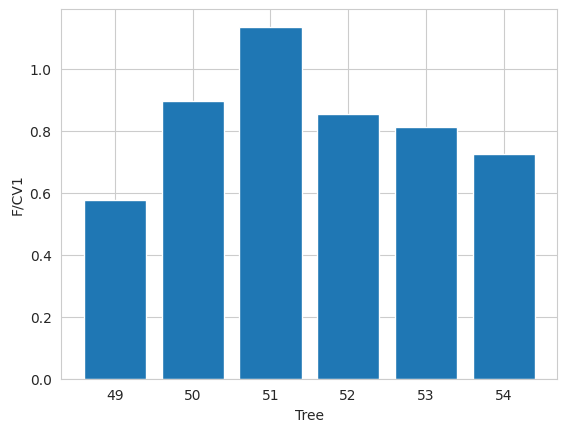

In [14]:
plt.bar(block_25_df['id'], block_25_df['F/cv1'])
plt.xlabel('Tree')
plt.ylabel('F/CV1')

In [9]:
#row_to_drow = 'row_111'
#tree_id = 1
#date = '221123'
#draw_tree_bb_from_tracks(row_tracks_25[row_to_drow][tree_id], os.path.join(block_25_path, date, row_to_drow, '1'), tree_id)

saving data into: /media/matans/My Book/FruitSpec/Apples_SA/025PINKO/221123/row_111/1/trees/1
arranging data


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:09<00:00,  7.09it/s]

Done


In [18]:
block_39_path = "/media/matans/My Book/FruitSpec/Apples_SA/039ROYA0"
block_39 = '039ROYA0'
block_39_df, row_tracks_39 = block_analysis(block_39_path, metadata_path, block_39)

In [16]:
block_39_df

,id,block,row,tree,side,tree_id,variety,Age,F,cv1,cv2,cv3,F/cv1,dcv1,dcv2,dcv3,dcv4,dcv5
0,57,039ROYA0,Row_111,1,A,1,Golden Delicious,46,1512,1424,784,525,1.061798,1275,705,466,346,255
1,58,039ROYA0,Row_111,2,A,2,Golden Delicious,46,2414,1632,1062,814,1.479167,1466,945,726,597,482
2,59,039ROYA0,Row_222,2,B,1,Golden Delicious,46,2414,1700,1097,764,1.420000,1439,905,602,399,265
3,60,039ROYA0,Row_222,1,B,2,Golden Delicious,46,1512,83,23,8,18.216867,70,20,7,0,0
4,61,039ROYA0,Row_333,3,A,1,Golden Delicious,46,1460,745,384,281,1.959732,687,362,257,190,142
5,62,039ROYA0,Row_333,4,A,2,Golden Delicious,46,1671,1142,540,321,1.463222,911,420,255,163,112
6,63,039ROYA0,Row_444,4,B,1,Golden Delicious,46,1671,1094,581,369,1.527422,1008,514,318,220,142
7,64,039ROYA0,Row_444,3,B,2,Golden Delicious,46,1460,848,481,317,1.721698,704,397,249,166,94
8,65,039ROYA0,Row_555,6,A,1,Royal Gala,46,919,766,423,293,1.199739,696,391,262,193,129
9,66,039ROYA0,Row_555,5,A,2,Royal Gala,46,1840,1106,521,334,1.663653,917,389,241,150,94


In [19]:
for key in list(row_tracks_39.keys()):
    print(f'number of sections in row {key} is {len(list(row_tracks_39[key].keys()))}')

number of sections in row row_111 is 2
number of sections in row row_222 is 2
number of sections in row row_333 is 2
number of sections in row row_444 is 2
number of sections in row row_555 is 3
number of sections in row row_666 is 2
number of sections in row row_777 is 2
number of sections in row row_888 is 2
